In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32 
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

(32, 256, 256, 3)
[0 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 1 2 2 1 1 1 0 0 0 1 0 1]


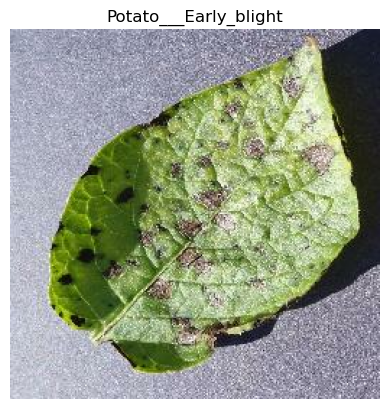

In [6]:
for image_batch, lable_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[lable_batch[0]])
    print(image_batch.shape)
    print(lable_batch.numpy())

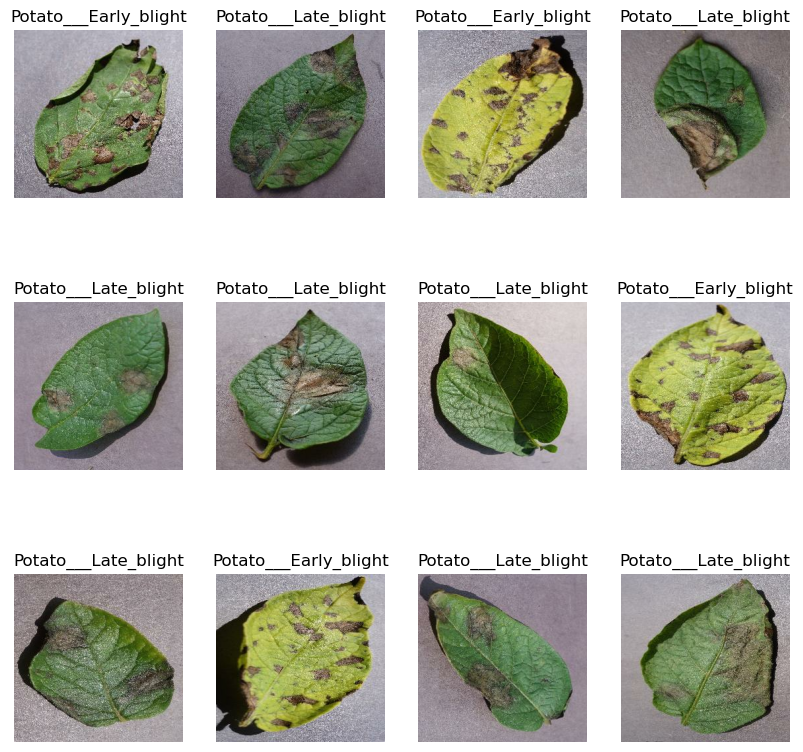

In [7]:
plt.figure(figsize = (10,10))
for image_batch, lable_batch in dataset.take(1):
    for i in range(12):  
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[lable_batch[i]])


In [8]:
# traning ==> 80%
# validation ==> 10%
# test ==> 10%

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds= dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [17]:
len(train_ds) ,len(val_ds), len(test_ds)

(54, 6, 8)

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

2.10.0
2.10.0


In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    tf.keras.Input(shape=input_shape), 
    resize_and_rescale,
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])


In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       

In [25]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 11s 189ms/step - loss: 0.0176 - accuracy: 0.9936 - val_loss: 0.1131 - val_accuracy: 0.9635
Epoch 2/50
54/54 [==============================] - 10s 183ms/step - loss: 0.0286 - accuracy: 0.9919 - val_loss: 0.0378 - val_accuracy: 0.9896
Epoch 3/50
54/54 [==============================] - 10s 187ms/step - loss: 0.0161 - accuracy: 0.9931 - val_loss: 0.0721 - val_accuracy: 0.9635
Epoch 4/50
54/54 [==============================] - 10s 175ms/step - loss: 0.0083 - accuracy: 0.9971 - val_loss: 0.0540 - val_accuracy: 0.9844
Epoch 5/50
54/54 [==============================] - 10s 176ms/step - loss: 0.0084 - accuracy: 0.9959 - val_loss: 0.0653 - val_accuracy: 0.9844
Epoch 6/50
54/54 [==============================] - 10s 176ms/step - loss: 0.0325 - accuracy: 0.9873 - val_loss: 0.0526 - val_accuracy: 0.9740
Epoch 7/50
54/54 [==============================] - 10s 175ms/step - loss: 0.0350 - accuracy: 0.9878 - val_loss: 0.0732 - val_accuracy: 0.9792

In [28]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 3s 38ms/step - loss: 0.0240 - accuracy: 0.9883


In [29]:
scores

[0.0239881444722414, 0.98828125]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
history.history['accuracy']

[0.9936342835426331,
 0.9918981194496155,
 0.9930555820465088,
 0.9971064925193787,
 0.9959490895271301,
 0.9872685074806213,
 0.9878472089767456,
 0.9936342835426331,
 0.9826388955116272,
 0.9971064925193787,
 0.9947916865348816,
 0.9982638955116272,
 0.9866898059844971,
 0.9971064925193787,
 0.9988425970077515,
 0.9994212985038757,
 0.9947916865348816,
 0.9837962985038757,
 0.9322916865348816,
 0.9895833134651184,
 0.9947916865348816,
 0.9953703880310059,
 0.9953703880310059,
 0.9971064925193787,
 0.9861111044883728,
 0.9959490895271301,
 0.9953703880310059,
 1.0,
 0.9866898059844971,
 0.9762731194496155,
 0.9971064925193787,
 0.9976851940155029,
 0.9994212985038757,
 0.9895833134651184,
 0.9571759104728699,
 0.9947916865348816,
 0.9965277910232544,
 0.9965277910232544,
 0.9953703880310059,
 0.9965277910232544,
 0.9953703880310059,
 0.9953703880310059,
 1.0,
 0.9982638955116272,
 0.9918981194496155,
 0.9953703880310059,
 0.9965277910232544,
 0.9924768805503845,
 0.9976851940155029,
 

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 16s 16s/step
predicted label: Potato___Late_blight


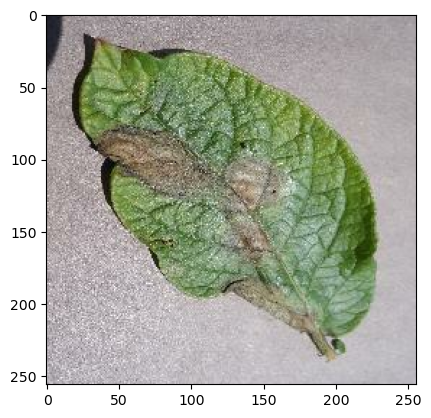

In [36]:
for images_batch, labels_batch in dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 42ms/step


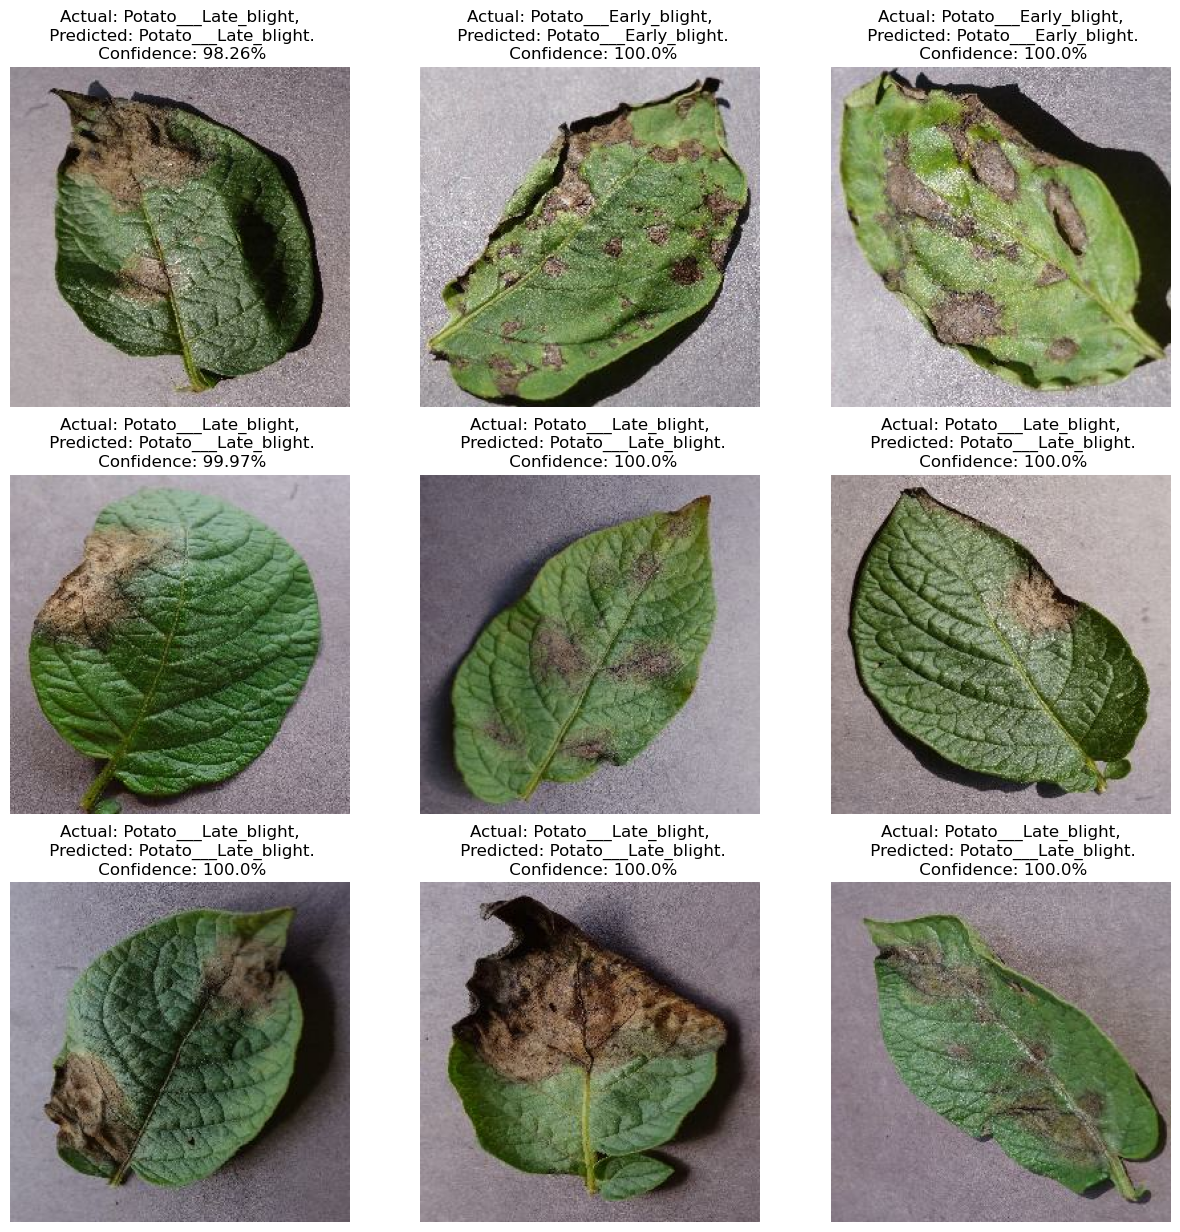

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [45]:
import os

# Create a new directory for the model
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")  # Save in SavedModel format

INFO:tensorflow:Assets written to: ../models/6\assets


INFO:tensorflow:Assets written to: ../models/6\assets


In [50]:
print(tf.version.VERSION)

2.10.0


In [46]:
# Load the model
new_model = tf.keras.models.load_model("../models/6")

# Test the model
predictions = new_model.predict(test_ds)
print(predictions)

8/8 [==============================] - 1s 59ms/step
[[7.21217202e-06 9.99992728e-01 3.25214011e-09]
 [9.99999881e-01 1.55139091e-07 1.70806576e-16]
 [9.99998808e-01 1.24846019e-06 1.70299752e-14]
 [9.63076587e-08 9.99999881e-01 4.42494347e-10]
 [9.99998569e-01 1.41409021e-06 1.08140645e-12]
 [3.48922100e-07 9.99999642e-01 5.57675295e-11]
 [7.31134904e-04 9.99265850e-01 3.02275453e-06]
 [6.53167126e-06 9.99993205e-01 2.95988627e-07]
 [9.99969959e-01 3.00348493e-05 9.07993502e-14]
 [9.99999762e-01 2.05881165e-07 1.64395265e-17]
 [1.84068888e-01 8.15931082e-01 2.24854624e-09]
 [9.99967098e-01 3.29190407e-05 1.32014188e-09]
 [1.50746373e-05 9.99984980e-01 7.81917553e-09]
 [9.99998689e-01 1.29734531e-06 1.21476145e-16]
 [8.50974811e-06 7.40802586e-01 2.59188890e-01]
 [9.99999166e-01 8.36880531e-07 5.89902459e-15]
 [4.46534932e-06 8.89052264e-03 9.91105020e-01]
 [1.00000000e+00 8.34562730e-09 8.87232271e-17]
 [5.16477439e-06 9.99994874e-01 1.53443896e-10]
 [1.00000000e+00 5.58334065e-12 4.81

1/1 [==============================] - 0s 29ms/step


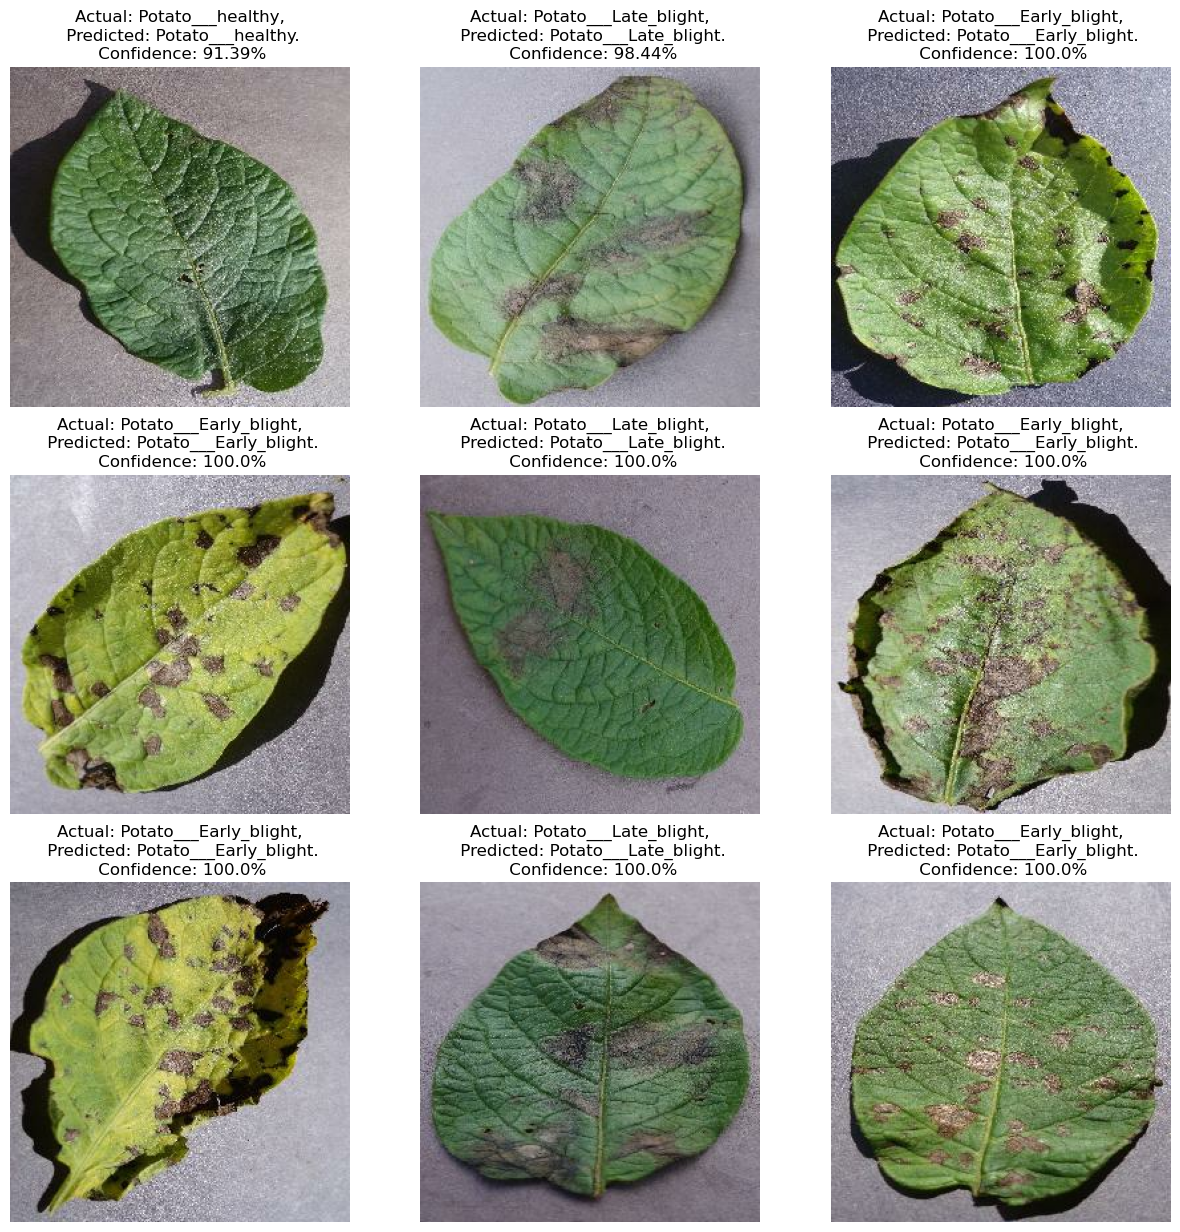

In [47]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(new_model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")